# Finding Supernova Neutrinos

To date we have only managed to detect the neutrinos from one supernova, which arrived at Earth on the 23rd February 1987 and is known by the snappy name SN1987A. In this project you will investigate the feasibility of idenitfying supernova neutrino events in a new type of detector a liquid argon time-projection chamber. These detectors give incredibly high-resolution 'images' of the charged-particle tracks produced when a neutrino interacts in the detector.

The data for this mini-project comes in the form of the following files:

| File | Description |
| ----------- | ----------- |
| larImages.npy | A numpy array of 10,000 100x100 pixel images |
| meta.npy | The meta information about the particles in the image |


The images show the energy deposited in the liquid argon detector in a small slice of space and time. The meta information contains the following 64 numbers  for each image. The [PDG code](https://pdg.lbl.gov/2019/reviews/rpp2019-rev-monte-carlo-numbering.pdf) is a number which identifies the particle type (e.g electron=11, electron-neutrino=12, etc.)

| Column | Description |
| ----------- | ----------- |
| 0 | Row number |
| 1 | Neutrino Energy (MeV) |
| 2 | Initial state particles (always 2) |
| 3 | Final state particles (varies) |
| 4-8 | Initial Particle 1: PDG code, Total Energy (MeV), $p_x$, $p_y$, $p_z$ |
| 9-13 | Initial Particle 2: PDG code, Total Energy (MeV), $p_x$, $p_y$, $p_z$ |
| 14-18 | Final Particle 1: PDG code, Total Energy (MeV), $p_x$, $p_y$, $p_z$ |
| 19-23 | Final Particle 2: PDG code, Total Energy (MeV), $p_x$, $p_y$, $p_z$ |
| $\vdots$ | Final Particle N: PDG code, Total Energy (MeV), $p_x$, $p_y$, $p_z$ |
| 59-63 | Final Particle 10: PDG code, Total Energy (MeV), $p_x$, $p_y$, $p_z$ |

## Machine learning tasks
1. Write a method to simulate electronic noise in the detector. The electronic noise is expected to follow a normal distribution.
2. Develop a machine learning classifier that can successfully classify 'clean' simulated neutrinos from 'empty' slices with some amount of 'electronic noise', how does your machine learning algorithm perform at differing noise levels?
3. Test your machine learning classifier on simulated neutrinos overlaid with noise, what level of additional noise starts to impact your machine learning algorithm

### Potential extensions
1. Write a method to generate noise in the 100x100 pixel images to simulate radioactive noise. This noise should be in the form of randomly placed Gaussian 'blobs' with appropriate energy. Repeat the above tests with radioactive noise. Is radioactive noise more or less of a problem than electronic noise?
2. Write a machine learning algorithm that can determine either the electron energy or (even better) the neutrino energy. What is the best energy resolution that can be achieved by such an algorithm?
3. Write a machine learning algorithm to effectively denoise either the electronic noise or radioactive noise datasets
4. Write a machine learning algorithm to determin the number of final state particles in the image



In [4]:
import numpy as np
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

#data files from google drive - colab notebooks folder
path1 = '/content/drive/MyDrive/Colab Notebooks/larImages.npy'
path2 = '/content/drive/MyDrive/Colab Notebooks/meta.npy'

Mounted at /content/drive


In [5]:
#loading images and meta data
images=np.load(path1)
meta=np.load(path2)

print("images.shape",images.shape)
print("meta.shape",meta.shape)

images.shape (10000, 100, 100)
meta.shape (10000, 64)


In [6]:
print("Row",int(meta[0][0]),"corresponds to a neutrino of",meta[0][1], "MeV and produced",int(meta[0][3]),"final state particles")

Row 0 corresponds to a neutrino of 21.2005 MeV and produced 6 final state particles


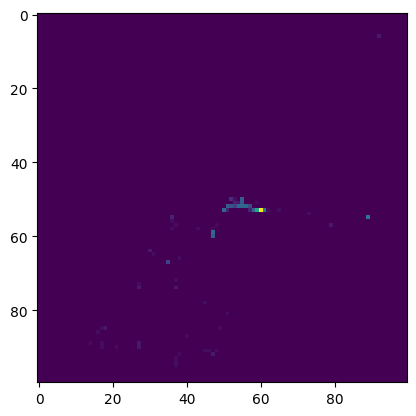

In [7]:
plt.figure()
plt.imshow(images[0])
plt.show()

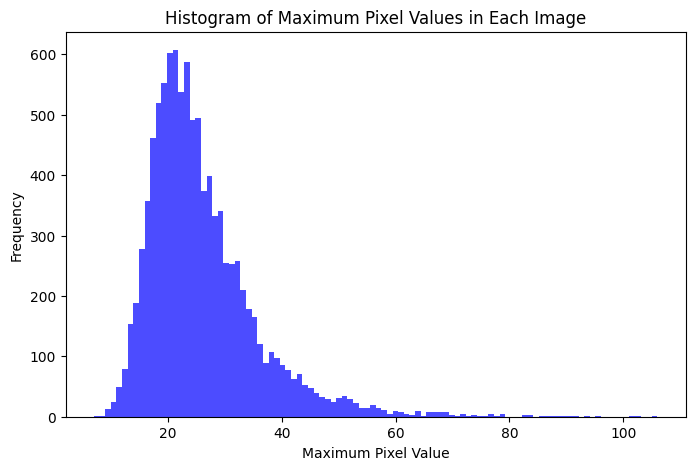

Maximum Pixel Value Statistics:
Min: 7.0
Max: 106.0
Mean: 25.6761
Std: 9.839968942532288


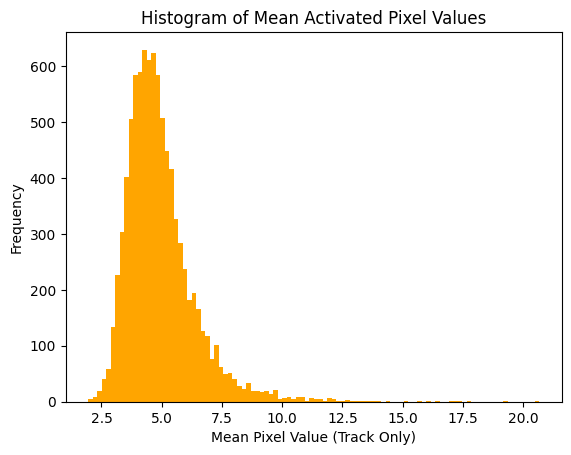

Mean Activated Pixel Value Statistics:
Min: 1.95
Max: 20.666666666666668
Mean: 4.952417890674882
Std: 1.4682585082311241


In [60]:
# Compute the maximum pixel value for each image in the dataset.
# `images` is a NumPy array of shape (n_images, height, width), we can compute:
max_pixel_values = np.max(images, axis=(1, 2))

plt.figure(figsize=(8, 5))
plt.hist(max_pixel_values, bins=100, color='blue', alpha=0.7)
plt.title("Histogram of Maximum Pixel Values in Each Image")
plt.xlabel("Maximum Pixel Value")
plt.ylabel("Frequency")
plt.show()

# Print summary statistics for the maximum pixel values
print("Maximum Pixel Value Statistics:")
print("Min:", np.min(max_pixel_values))
print("Max:", np.max(max_pixel_values))
print("Mean:", np.mean(max_pixel_values))
print("Std:", np.std(max_pixel_values))

mean_vals_activated = [
    np.mean(img[img > 0]) for img in images[:9000] if np.any(img > 0)
]

plt.hist(mean_vals_activated, bins=100, color='orange')
plt.title("Histogram of Mean Activated Pixel Values")
plt.xlabel("Mean Pixel Value (Track Only)")
plt.ylabel("Frequency")
plt.show()

# Compute statistics for the mean activated pixel values
print("Mean Activated Pixel Value Statistics:")
print("Min:", np.min(mean_vals_activated))
print("Max:", np.max(mean_vals_activated))
print("Mean:", np.mean(mean_vals_activated))
print("Std:", np.std(mean_vals_activated))


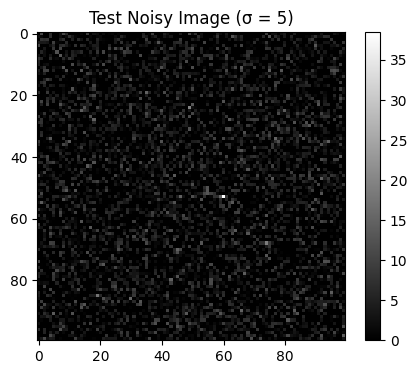

In [9]:
def add_noise_to_image(image, noise_std):
    """
    Adds Gaussian noise to an image.

    Parameters:
    - image: np.ndarray, the original image.
    - noise_std: float, the standard deviation (σ) of the Gaussian noise.

    Returns:
    - noisy_image: np.ndarray, the image with added noise. Negative values are clipped to 0.
    """
    noise = np.random.normal(loc=0, scale=noise_std, size=image.shape)
    noisy_image = np.clip(image + noise, 0, None)
    return noisy_image

# Test the function on one image from `images` (this is just to ensure it runs)
test_image = images[0]
test_noisy = add_noise_to_image(test_image, noise_std=5)
plt.figure(figsize=(5,4))
plt.imshow(test_noisy, cmap='gray')
plt.title("Test Noisy Image (σ = 5)")
plt.colorbar()
plt.show()

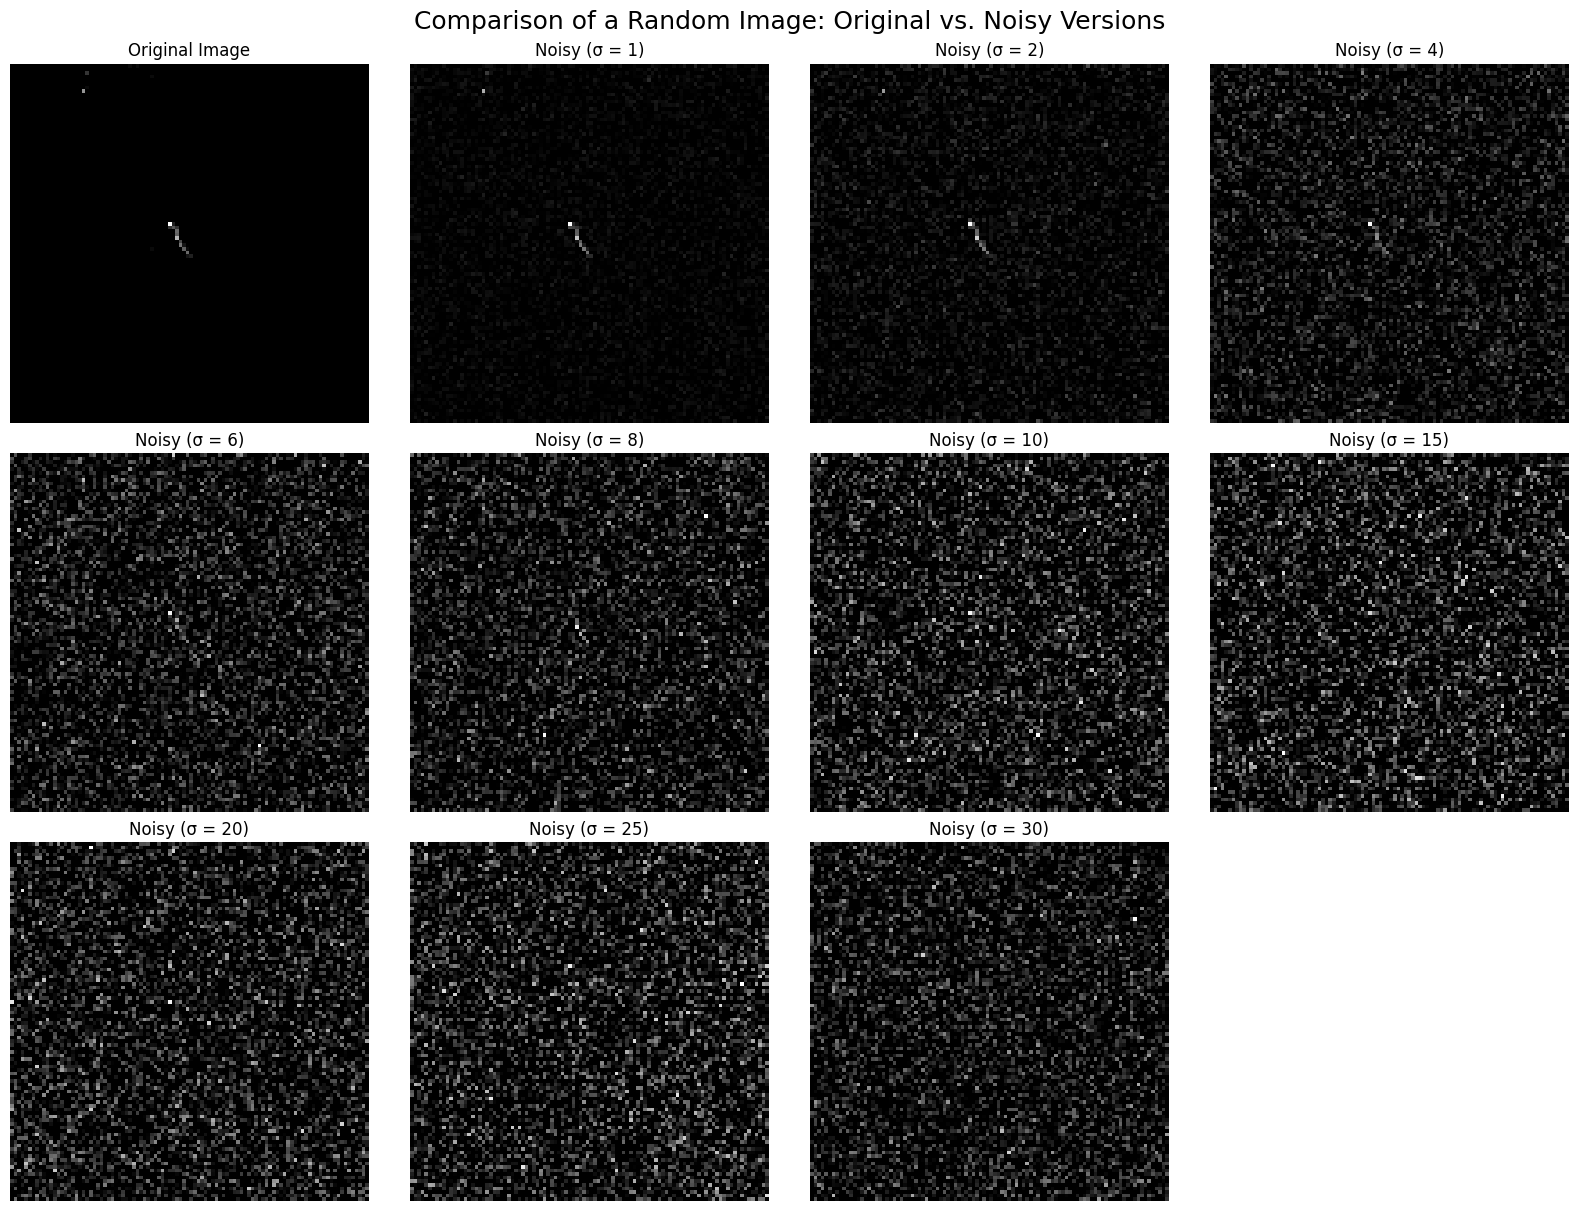

In [10]:
import math

# Define noise levels
noise_levels = [1, 2, 4, 6, 8, 10, 15, 20, 25, 30]

# Total images = 1 original + len(noise_levels)
n_images = len(noise_levels) + 1

# Calculate layout: e.g., 4 columns, enough rows to fit everything
n_cols = 4
n_rows = math.ceil(n_images / n_cols)

# Create figure and axes
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 4), constrained_layout=True)
axes = axes.flatten()  # Flatten in case of multiple rows

# Display the original image
original_image = images[1]
axes[0].imshow(original_image, cmap='gray')
axes[0].set_title("Original Image")
axes[0].axis('off')

# Display noisy images
for i, sigma in enumerate(noise_levels):
    noisy_img = add_noise_to_image(original_image, sigma)
    axes[i + 1].imshow(noisy_img, cmap='gray')
    axes[i + 1].set_title(f"Noisy (σ = {sigma})")
    axes[i + 1].axis('off')

# Hide any extra subplots (if layout has more spaces than needed)
for j in range(len(noise_levels) + 1, len(axes)):
    axes[j].axis('off')

plt.suptitle("Comparison of a Random Image: Original vs. Noisy Versions", fontsize=18)
plt.show()

In [11]:
def compute_snr_mean_nonzero(original, noisy):
    """
    Computes SNR as:
    mean of activated pixels in original image /
    mean of activated pixels in added noise.

    Parameters:
    - original: np.ndarray, original image (signal)
    - noisy: np.ndarray, image with added noise

    Returns:
    - snr: float, new SNR definition
    """
    noise_only = noisy - original
    noise_only = np.clip(noise_only, 0, None)  # Ensure non-negative noise

    signal_active_pixels = original[original > 0]
    noise_active_pixels = noise_only[noise_only > 0]

    if len(signal_active_pixels) == 0 or len(noise_active_pixels) == 0:
        return np.nan  # Skip images with no track or no noise spikes

    return np.mean(signal_active_pixels) / np.mean(noise_active_pixels)

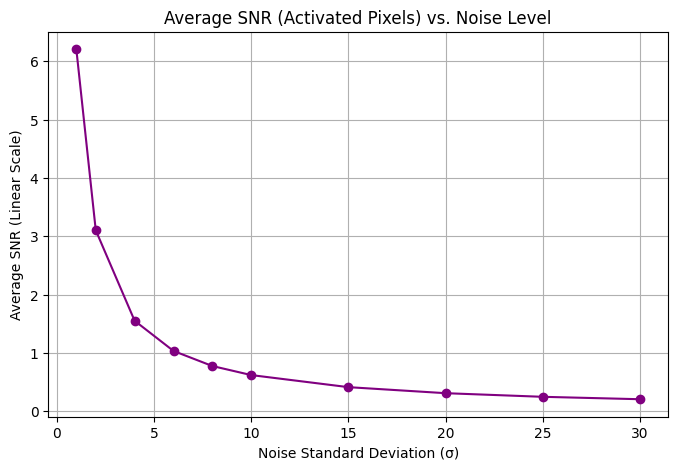

In [12]:
avg_snr_linear = []

for sigma in noise_levels:
    snr_list = []
    for img in images:
        noisy_img = add_noise_to_image(img, sigma)
        snr = compute_snr_mean_nonzero(img, noisy_img)
        if not np.isnan(snr):
            snr_list.append(snr)
    avg_snr_linear.append(np.mean(snr_list))

# Plot SNR
plt.figure(figsize=(8, 5))
plt.plot(noise_levels, avg_snr_linear, marker='o', linestyle='-', color='purple')
plt.xlabel("Noise Standard Deviation (σ)")
plt.ylabel("Average SNR (Linear Scale)")
plt.title("Average SNR (Activated Pixels) vs. Noise Level")
plt.grid(True)
plt.show()

In [13]:
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import confusion_matrix, roc_curve, auc

def minmax_norm(image):
    """Min-max normalizes an image to the range [0, 1]."""
    m = np.min(image)
    M = np.max(image)
    if M - m == 0:
        return image
    return (image - m) / (M - m)

# Define the noise levels and number of levels.
noise_levels = [1, 2, 4, 6, 8, 10, 15, 20, 25, 30]
num_levels = len(noise_levels)

In [14]:
# Positive class for training: Use the first 8000 images from `images`
pos_train = images[:8000]  # shape: (8000, 100, 100)
# For positive examples, 4000 will be clean and 4000 will be noisy.
clean_pos_train = pos_train[:4000]
noisy_pos_train_source = pos_train[4000:]  # 4000 images to be made noisy

# Split the 4000 images equally among the 10 noise levels: 400 per level.
num_per_level_pos = 4000 // num_levels  # 400
noisy_pos_train = []
for i, sigma in enumerate(noise_levels):
    start = i * num_per_level_pos
    end = start + num_per_level_pos
    subset = noisy_pos_train_source[start:end]
    # Apply noise to each image in the subset.
    noisy_subset = np.array([add_noise_to_image(img, sigma) for img in subset])
    noisy_pos_train.append(noisy_subset)
noisy_pos_train = np.concatenate(noisy_pos_train, axis=0)  # shape: (4000, 100, 100)

# Combine clean and noisy positive images.
pos_train_final = np.concatenate([clean_pos_train, noisy_pos_train], axis=0)  # (8000, 100, 100)
pos_train_labels = np.ones(pos_train_final.shape[0])

# Negative class for training: Generate 8000 blank images with noise overlaid.
# Add σ = 0 only for the negative class generation
noise_levels_neg = [0, 1, 2, 4, 6, 8, 10, 15, 20, 25, 30]  # Includes noise-free blank images

num_neg_train = 8000
num_per_level_neg = num_neg_train // len(noise_levels_neg)

neg_train = []
for sigma in noise_levels_neg:
    blank_images = [np.zeros((100, 100)) for _ in range(num_per_level_neg)]
    noisy_blank = np.array([
        np.clip(np.random.normal(0, sigma, (100, 100)), 0, None)
        for _ in blank_images
    ])
    neg_train.append(noisy_blank)
neg_train = np.concatenate(neg_train, axis=0)
neg_train_labels = np.zeros(neg_train.shape[0])
# Pad if needed to reach exactly 8000 samples
if neg_train.shape[0] < 8000:
    extra = 8000 - neg_train.shape[0]
    neg_train = np.concatenate([neg_train, neg_train[:extra]], axis=0)
    neg_train_labels = np.concatenate([neg_train_labels, np.zeros(extra)], axis=0)

# Combine positive and negative training examples.
X_train = np.concatenate([pos_train_final, neg_train], axis=0)  # (16000, 100, 100)
y_train = np.concatenate([pos_train_labels, neg_train_labels], axis=0)

# Normalize each image using min–max normalization.
X_train = np.array([minmax_norm(img) for img in X_train])
# Expand dims to add channel dimension for Conv2D: (n, 100, 100, 1)
X_train = np.expand_dims(X_train, axis=-1)

In [15]:
# Positive validation: Next 1000 images from `images` (indices 8000 to 8999)
pos_val = images[8000:9000]  # (1000, 100, 100)
# Out of these, 500 are kept clean and 500 will have noise.
clean_pos_val = pos_val[:500]
noisy_pos_val_source = pos_val[500:]  # 500 images for noise overlay

# Split 500 images equally among 10 noise levels: 50 per level.
num_per_level_pos_val = 500 // num_levels  # 50
noisy_pos_val = []
for i, sigma in enumerate(noise_levels):
    start = i * num_per_level_pos_val
    end = start + num_per_level_pos_val
    subset = noisy_pos_val_source[start:end]
    noisy_subset = np.array([add_noise_to_image(img, sigma) for img in subset])
    noisy_pos_val.append(noisy_subset)
noisy_pos_val = np.concatenate(noisy_pos_val, axis=0)  # (500, 100, 100)
# Combine clean and noisy positive validation images.
pos_val_final = np.concatenate([clean_pos_val, noisy_pos_val], axis=0)  # (1000, 100, 100)
pos_val_labels = np.ones(pos_val_final.shape[0])

# Negative validation: include σ = 0 using noise_levels_neg (already defined)
num_neg_val = 1000
num_per_level_neg_val = num_neg_val // len(noise_levels_neg)

neg_val = []
for sigma in noise_levels_neg:
    blank_images = [np.zeros((100, 100)) for _ in range(num_per_level_neg_val)]
    noisy_blank = np.array([
        np.clip(np.random.normal(0, sigma, (100, 100)), 0, None)
        for _ in blank_images
    ])
    neg_val.append(noisy_blank)
neg_val = np.concatenate(neg_val, axis=0)
neg_val_labels = np.zeros(neg_val.shape[0])
# Pad if needed to reach exactly 1000 samples
if neg_val.shape[0] < 1000:
    extra = 1000 - neg_val.shape[0]
    neg_val = np.concatenate([neg_val, neg_val[:extra]], axis=0)
    neg_val_labels = np.concatenate([neg_val_labels, np.zeros(extra)], axis=0)

# Combine validation sets.
X_val = np.concatenate([pos_val_final, neg_val], axis=0)  # (2000, 100, 100)
y_val = np.concatenate([pos_val_labels, neg_val_labels], axis=0)
X_val = np.array([minmax_norm(img) for img in X_val])
X_val = np.expand_dims(X_val, axis=-1)

In [16]:
# Positive test: Last 1000 neutrino images from `images` (indices 9000 to 9999) with NO noise overlaid.
pos_test = images[9000:10000]  # (1000, 100, 100)
pos_test_labels = np.ones(pos_test.shape[0])

# Negative test: Generate 1000 blank images with noise overlaid (split equally).
num_neg_test = 1000
num_per_level_neg_test = num_neg_test // num_levels  # 100 per level
neg_test = []
for sigma in noise_levels:
    blank_images = [np.zeros((100,100)) for _ in range(num_per_level_neg_test)]
    noisy_blank = np.array([np.clip(np.random.normal(0, sigma, (100,100)), 0, None)
                             for _ in blank_images])
    neg_test.append(noisy_blank)
neg_test = np.concatenate(neg_test, axis=0)  # (1000, 100, 100)
neg_test_labels = np.zeros(neg_test.shape[0])

# Combine test sets.
X_test = np.concatenate([pos_test, neg_test], axis=0)  # (2000, 100, 100)
y_test = np.concatenate([pos_test_labels, neg_test_labels], axis=0)
X_test = np.array([minmax_norm(img) for img in X_test])
X_test = np.expand_dims(X_test, axis=-1)

# Print shapes to verify.
print("X_train shape:", X_train.shape, "y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape, "y_val shape:", y_val.shape)
print("X_test shape:", X_test.shape, "y_test shape:", y_test.shape)

X_train shape: (16000, 100, 100, 1) y_train shape: (16000,)
X_val shape: (2000, 100, 100, 1) y_val shape: (2000,)
X_test shape: (2000, 100, 100, 1) y_test shape: (2000,)


In [17]:
# Create the model
model1 = keras.models.Sequential()

# First convolutional block
model1.add(keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(100, 100, 1)))
model1.add(keras.layers.BatchNormalization())
model1.add(keras.layers.MaxPooling2D((2, 2)))

# Second convolutional block
model1.add(keras.layers.Conv2D(128, (3, 3), activation='relu'))
model1.add(keras.layers.BatchNormalization())
model1.add(keras.layers.MaxPooling2D((2, 2)))

# Third convolutional block
model1.add(keras.layers.Conv2D(128, (3, 3), activation='relu'))
model1.add(keras.layers.BatchNormalization())
model1.add(keras.layers.MaxPooling2D((2, 2)))

# Flatten and dense layers
model1.add(keras.layers.Flatten())
model1.add(keras.layers.Dense(64, activation='relu'))
model1.add(keras.layers.Dropout(0.3))
model1.add(keras.layers.Dense(64, activation='relu'))

# Output layer (binary classification)
model1.add(keras.layers.Dense(1, activation='sigmoid'))

# Compile the model
loss = keras.losses.BinaryCrossentropy
model1.compile(optimizer='adam', loss=loss, metrics=['accuracy'])

# Display model architecture
model1.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)                    │ (None, 98, 98, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 98, 98, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 49, 49, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 47, 47, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 47, 47, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 23, 23, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 21, 21, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 21, 21, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 10, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │         819,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,046,849 (3.99 MB)

 Trainable params: 1,046,209 (3.99 MB)

 Non-trainable params: 640 (2.50 KB)

In [18]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',     # Stop when validation loss stops improving
    patience=5,             # Wait 5 epochs before stopping
    restore_best_weights=True,  # Load best weights after stopping
    verbose=1
)

from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train, random_state=42)


# Train the model
history = model1.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stop],
    verbose=1  # Shows per-epoch progress bar + metrics
)


Epoch 1/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - accuracy: 0.7662 - loss: 0.7125 - val_accuracy: 0.5000 - val_loss: 10.6723
Epoch 2/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.8439 - loss: 0.3524 - val_accuracy: 0.8490 - val_loss: 0.3428
Epoch 3/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.8501 - loss: 0.3418 - val_accuracy: 0.8110 - val_loss: 0.3933
Epoch 4/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.8529 - loss: 0.3404 - val_accuracy: 0.8060 - val_loss: 0.7969
Epoch 5/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.8651 - loss: 0.3206 - val_accuracy: 0.8045 - val_loss: 1.4997
Epoch 6/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.8614 - loss: 0.3195 - val_accuracy: 0.8595 - val_loss: 0.3236
Epoch 7/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.8676 - loss: 0.3084 - val_accuracy: 0.8450 - val_loss: 0.3505
Epoch 8/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.8653 - loss: 0.3173 -

In [19]:
test_noise_levels = [0] + noise_levels  # Include no noise
test_accuracy_results = []
test_loss_results = []
test_results_dict = {}

for sigma in test_noise_levels:
    # Positive test: last 1000 clean neutrino images
    pos_test = images[9000:10000]
    pos_test_labels = np.ones(pos_test.shape[0])

    # Negative test: 1000 blank noisy images with current sigma
    neg_test = np.array([
        np.clip(np.random.normal(0, sigma, (100, 100)), 0, None)
        for _ in range(1000)
    ])
    neg_test_labels = np.zeros(1000)

    # Combine and normalize
    X_test_set = np.concatenate([pos_test, neg_test], axis=0)
    y_test_set = np.concatenate([pos_test_labels, neg_test_labels], axis=0)
    X_test_set = np.array([minmax_norm(img) for img in X_test_set])
    X_test_set = np.expand_dims(X_test_set, axis=-1)

    # Evaluate
    loss, acc = model1.evaluate(X_test_set, y_test_set, verbose=0)
    test_accuracy_results.append(acc)
    test_loss_results.append(loss)
    test_results_dict[sigma] = {'loss': loss, 'accuracy': acc}

    print(f"Noise level: {sigma:>2} - Test Loss: {loss:.4f} - Test Accuracy: {acc:.4f}")

Noise level:  0 - Test Loss: 0.0000 - Test Accuracy: 1.0000
Noise level:  1 - Test Loss: 0.1170 - Test Accuracy: 0.9920
Noise level:  2 - Test Loss: 0.1200 - Test Accuracy: 0.9895
Noise level:  4 - Test Loss: 0.1123 - Test Accuracy: 0.9965
Noise level:  6 - Test Loss: 0.1140 - Test Accuracy: 0.9935
Noise level:  8 - Test Loss: 0.1171 - Test Accuracy: 0.9905
Noise level: 10 - Test Loss: 0.1173 - Test Accuracy: 0.9945
Noise level: 15 - Test Loss: 0.1189 - Test Accuracy: 0.9910
Noise level: 20 - Test Loss: 0.1133 - Test Accuracy: 0.9950
Noise level: 25 - Test Loss: 0.1135 - Test Accuracy: 0.9945
Noise level: 30 - Test Loss: 0.1143 - Test Accuracy: 0.9945


In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score

# Test noise levels
test_noise_levels = [0, 1, 2, 4, 6, 8, 10, 15, 20, 25, 30]

# Results to store
accuracy_per_sigma = []
confusion_matrices = {}

for sigma in test_noise_levels:
    # Positive class: last 1000 clean neutrino images
    pos_test = images[9000:10000]
    pos_labels = np.ones(pos_test.shape[0])

    # Negative class: 1000 noise-only images at current sigma
    neg_test = np.array([
        np.clip(np.random.normal(0, sigma, (100, 100)), 0, None)
        for _ in range(1000)
    ])
    neg_labels = np.zeros(neg_test.shape[0])

    # Combine and normalize
    X_test_sigma = np.concatenate([pos_test, neg_test], axis=0)
    y_true = np.concatenate([pos_labels, neg_labels], axis=0)

    X_test_sigma = np.array([minmax_norm(img) for img in X_test_sigma])
    X_test_sigma = np.expand_dims(X_test_sigma, axis=-1)

    # Predict
    y_pred_probs = model1.predict(X_test_sigma, verbose=0)
    y_pred = np.round(y_pred_probs).astype(int).flatten()

    # Accuracy
    acc = accuracy_score(y_true, y_pred)
    accuracy_per_sigma.append(acc)

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    confusion_matrices[sigma] = cm

    # Optional: print
    print(f"σ = {sigma:<2} | Accuracy = {acc:.4f} | Confusion Matrix: TP={cm[1,1]}, FN={cm[1,0]}, FP={cm[0,1]}, TN={cm[0,0]}")


σ = 0  | Accuracy = 1.0000 | Confusion Matrix: TP=1000, FN=0, FP=0, TN=1000
σ = 1  | Accuracy = 0.9965 | Confusion Matrix: TP=1000, FN=0, FP=7, TN=993
σ = 2  | Accuracy = 0.9915 | Confusion Matrix: TP=1000, FN=0, FP=17, TN=983
σ = 4  | Accuracy = 0.9965 | Confusion Matrix: TP=1000, FN=0, FP=7, TN=993
σ = 6  | Accuracy = 0.9920 | Confusion Matrix: TP=1000, FN=0, FP=16, TN=984
σ = 8  | Accuracy = 0.9935 | Confusion Matrix: TP=1000, FN=0, FP=13, TN=987
σ = 10 | Accuracy = 0.9960 | Confusion Matrix: TP=1000, FN=0, FP=8, TN=992
σ = 15 | Accuracy = 0.9925 | Confusion Matrix: TP=1000, FN=0, FP=15, TN=985
σ = 20 | Accuracy = 0.9930 | Confusion Matrix: TP=1000, FN=0, FP=14, TN=986
σ = 25 | Accuracy = 0.9945 | Confusion Matrix: TP=1000, FN=0, FP=11, TN=989
σ = 30 | Accuracy = 0.9915 | Confusion Matrix: TP=1000, FN=0, FP=17, TN=983


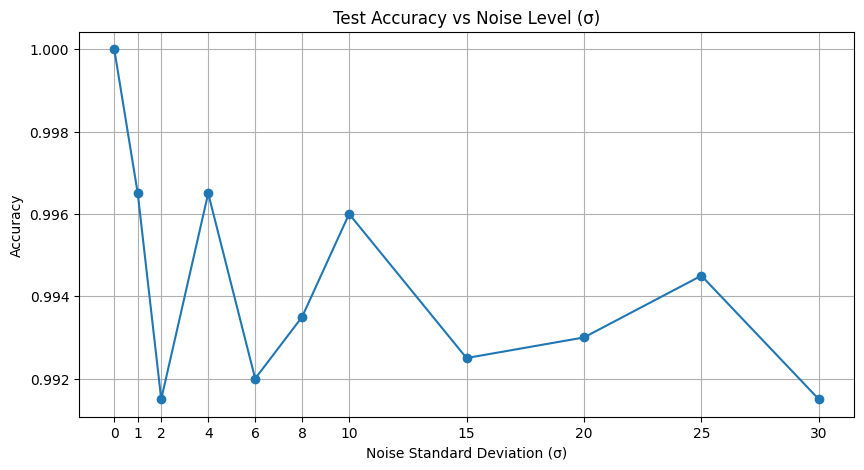

In [21]:
plt.figure(figsize=(10, 5))
plt.plot(test_noise_levels, accuracy_per_sigma, marker='o')
plt.title("Test Accuracy vs Noise Level (σ)")
plt.xlabel("Noise Standard Deviation (σ)")
plt.ylabel("Accuracy")
plt.grid(True)
plt.xticks(test_noise_levels)
plt.show()


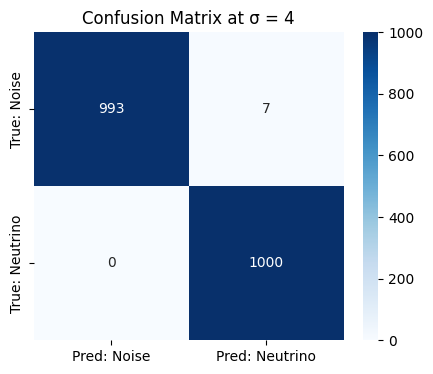

In [22]:
sigma_to_plot = 4
cm = confusion_matrices[sigma_to_plot]

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Pred: Noise', 'Pred: Neutrino'],
            yticklabels=['True: Noise', 'True: Neutrino'])
plt.title(f"Confusion Matrix at σ = {sigma_to_plot}")
plt.show()


Using Autoencoder

In [45]:
# Define initial clean images
base_clean_images = images[:9000]  # Neutrino-containing (positives)

# Define noise levels to use (including 0)
noise_levels = [0, 1, 2, 4, 6, 8, 10, 15, 20, 25, 30]
n_levels = len(noise_levels)

# Make neutrino images divisible evenly
images_per_level = len(base_clean_images) // n_levels
extra = len(base_clean_images) % n_levels
if extra > 0:
    pad_imgs = base_clean_images[-extra:]
    base_clean_images = np.concatenate([base_clean_images, pad_imgs], axis=0)
images_per_level = len(base_clean_images) // n_levels

# --- Positive data (neutrino + noise → clean neutrino) ---
noisy_images_pos = []
clean_images_pos = []

for i, sigma in enumerate(noise_levels):
    start_idx = i * images_per_level
    end_idx = start_idx + images_per_level
    group = base_clean_images[start_idx:end_idx]

    noisy = np.array([
        np.clip(img + np.random.normal(0, sigma, img.shape), 0, None)
        for img in group
    ])
    noisy_images_pos.append(noisy)
    clean_images_pos.append(group)

noisy_images_pos = np.concatenate(noisy_images_pos, axis=0)
clean_images_pos = np.concatenate(clean_images_pos, axis=0)

# --- Negative data (noise only → all zeros) ---
blank_images = np.zeros_like(base_clean_images[:len(noisy_images_pos)])  # blank images
noisy_images_neg = []

# Add noise to blank images at same scale
images_per_level_neg = len(blank_images) // n_levels
for i, sigma in enumerate(noise_levels):
    start_idx = i * images_per_level_neg
    end_idx = start_idx + images_per_level_neg
    group = blank_images[start_idx:end_idx]

    noisy = np.array([
        np.clip(np.random.normal(0, sigma, img.shape), 0, None)
        for img in group
    ])
    noisy_images_neg.append(noisy)

noisy_images_neg = np.concatenate(noisy_images_neg, axis=0)
clean_images_neg = np.zeros_like(noisy_images_neg)  # target is zero (blank)

# --- Combine both classes ---
noisy_images = np.concatenate([noisy_images_pos, noisy_images_neg], axis=0)
clean_images = np.concatenate([clean_images_pos, clean_images_neg], axis=0)

# Normalize
def minmax_norm(img):
    m, M = np.min(img), np.max(img)
    return img if M - m == 0 else (img - m) / (M - m)

noisy_images = np.array([minmax_norm(img) for img in noisy_images])
clean_images = np.array([minmax_norm(img) for img in clean_images])

# Expand dims
noisy_images = np.expand_dims(noisy_images, axis=-1)
clean_images = np.expand_dims(clean_images, axis=-1)

# Shuffle in sync
from sklearn.utils import shuffle
noisy_images, clean_images = shuffle(noisy_images, clean_images, random_state=42)



In [46]:
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input

input_img = keras.Input(shape=(100, 100, 1))

# --- Encoder ---
x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)  # 50x50

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)  # 25x25

# --- Decoder ---
x = Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)  # 50x50

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)  # 100x100

decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# Compile the model
autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

autoencoder.summary()





Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 100, 100, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_44 (Conv2D)                   │ (None, 100, 100, 64)        │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 50, 50, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_45 (Conv2D)                   │ (None, 50, 50, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 25, 25, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_46 (Conv2D)                   │ (None, 25, 25, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_9 (UpSampling2D)       │ (None, 50, 50, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_47 (Conv2D)                   │ (None, 50, 50, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_10 (UpSampling2D)      │ (None, 100, 100, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_48 (Conv2D)                   │ (None, 100, 100, 1)         │             577 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 296,449 (1.13 MB)

 Trainable params: 296,449 (1.13 MB)

 Non-trainable params: 0 (0.00 B)

In [47]:
autoencoder.fit(noisy_images, clean_images,
                epochs=30,
                batch_size=32,
                validation_split=0.1,callbacks=[early_stop])


Epoch 1/30
507/507 ━━━━━━━━━━━━━━━━━━━━ 23s 39ms/step - loss: 0.0338 - val_loss: 0.0033
Epoch 2/30
507/507 ━━━━━━━━━━━━━━━━━━━━ 17s 33ms/step - loss: 0.0033 - val_loss: 0.0032
Epoch 3/30
507/507 ━━━━━━━━━━━━━━━━━━━━ 16s 32ms/step - loss: 0.0031 - val_loss: 0.0031
Epoch 4/30
507/507 ━━━━━━━━━━━━━━━━━━━━ 16s 32ms/step - loss: 0.0030 - val_loss: 0.0031
Epoch 5/30
507/507 ━━━━━━━━━━━━━━━━━━━━ 16s 32ms/step - loss: 0.0030 - val_loss: 0.0032
Epoch 6/30
507/507 ━━━━━━━━━━━━━━━━━━━━ 16s 32ms/step - loss: 0.0030 - val_loss: 0.0030
Epoch 7/30
507/507 ━━━━━━━━━━━━━━━━━━━━ 16s 32ms/step - loss: 0.0030 - val_loss: 0.0030
Epoch 8/30
507/507 ━━━━━━━━━━━━━━━━━━━━ 16s 32ms/step - loss: 0.0030 - val_loss: 0.0029
Epoch 9/30
507/507 ━━━━━━━━━━━━━━━━━━━━ 16s 32ms/step - loss: 0.0029 - val_loss: 0.0029
Epoch 10/30
507/507 ━━━━━━━━━━━━━━━━━━━━ 16s 32ms/step - loss: 0.0029 - val_loss: 0.0029
Epoch 11/30
507/507 ━━━━━━━━━━━━━━━━━━━━ 16s 32ms/step - loss: 0.0029 - val_loss: 0.0029
Epoch 12/30
507/507 ━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


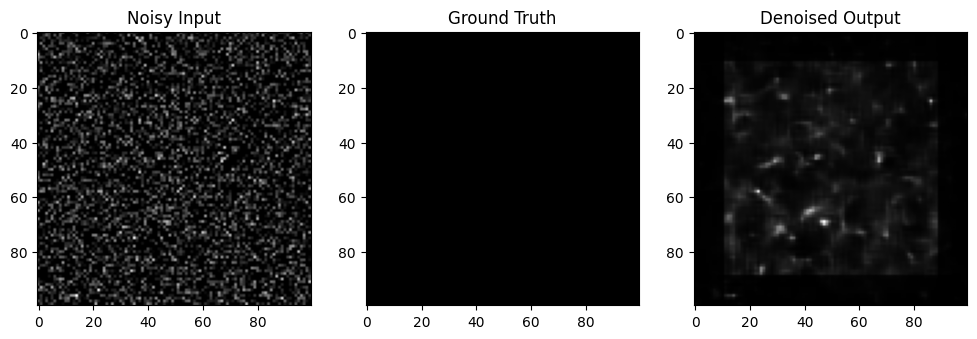

In [48]:
import matplotlib.pyplot as plt

# Pick random sample
idx = np.random.randint(0, len(noisy_images))
denoised = autoencoder.predict(np.expand_dims(noisy_images[idx], axis=0))[0]

# Plot
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].imshow(noisy_images[idx].squeeze(), cmap='gray')
ax[0].set_title("Noisy Input")
ax[1].imshow(clean_images[idx].squeeze(), cmap='gray')
ax[1].set_title("Ground Truth")
ax[2].imshow(denoised.squeeze(), cmap='gray')
ax[2].set_title("Denoised Output")
plt.show()


In [50]:
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt

fpr_raw, fnr_raw = [], []
fpr_denoised, fnr_denoised = [], []

acc_raw = []
acc_denoised = []

# Include 0 noise level
noise_levels_with_zero = [0, 1, 2, 4, 6, 8, 10, 15, 20, 25, 30]

# Clean neutrino images (positive class)
pos_test = images[9000:10000]
pos_labels = np.ones(pos_test.shape[0])

for sigma in noise_levels_with_zero:
    # Generate 1000 noise-only images at this sigma
    neg_test = np.array([
        np.clip(np.random.normal(0, sigma, (100, 100)), 0, None)
        for _ in range(1000)
    ])
    neg_labels = np.zeros(neg_test.shape[0])

    # Combine and normalize
    X_test = np.concatenate([pos_test, neg_test], axis=0)
    y_test = np.concatenate([pos_labels, neg_labels], axis=0)
    X_test = np.array([minmax_norm(img) for img in X_test])
    X_test = np.expand_dims(X_test, axis=-1)

    # --- Raw classifier ---
    y_pred_raw = (model1.predict(X_test, verbose=0) > 0.5).astype(int).flatten()
    cm_raw = confusion_matrix(y_test, y_pred_raw)
    tn, fp, fn, tp = cm_raw.ravel()
    fpr_raw.append(fp / (fp + tn))
    fnr_raw.append(fn / (fn + tp))
    acc_raw.append(accuracy_score(y_test, y_pred_raw))

    # --- Autoencoder + classifier ---
    X_test_denoised = autoencoder.predict(X_test, verbose=0)
    y_pred_denoised = (model1.predict(X_test_denoised, verbose=0) > 0.5).astype(int).flatten()
    cm_denoised = confusion_matrix(y_test, y_pred_denoised)
    tn, fp, fn, tp = cm_denoised.ravel()
    fpr_denoised.append(fp / (fp + tn))
    fnr_denoised.append(fn / (fn + tp))
    acc_denoised.append(accuracy_score(y_test, y_pred_denoised))



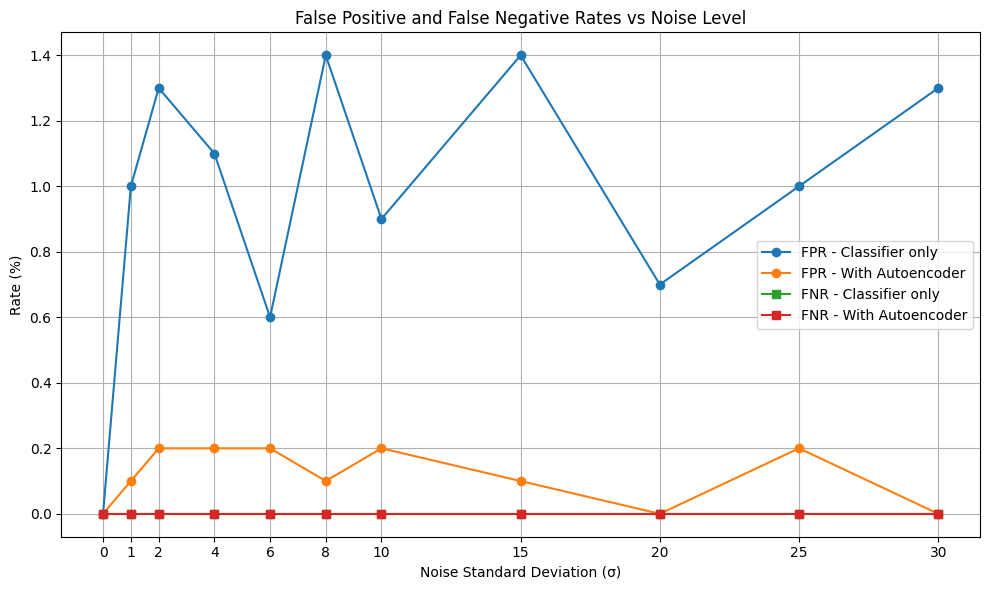

In [51]:
plt.figure(figsize=(10, 6))

plt.plot(noise_levels_with_zero, [100*x for x in fpr_raw], label='FPR - Classifier only', marker='o')
plt.plot(noise_levels_with_zero, [100*x for x in fpr_denoised], label='FPR - With Autoencoder', marker='o')

plt.plot(noise_levels_with_zero, [100*x for x in fnr_raw], label='FNR - Classifier only', marker='s')
plt.plot(noise_levels_with_zero, [100*x for x in fnr_denoised], label='FNR - With Autoencoder', marker='s')

plt.xlabel("Noise Standard Deviation (σ)")
plt.ylabel("Rate (%)")
plt.title("False Positive and False Negative Rates vs Noise Level")
plt.grid(True)
plt.legend()
plt.xticks(noise_levels_with_zero)
plt.tight_layout()
plt.show()



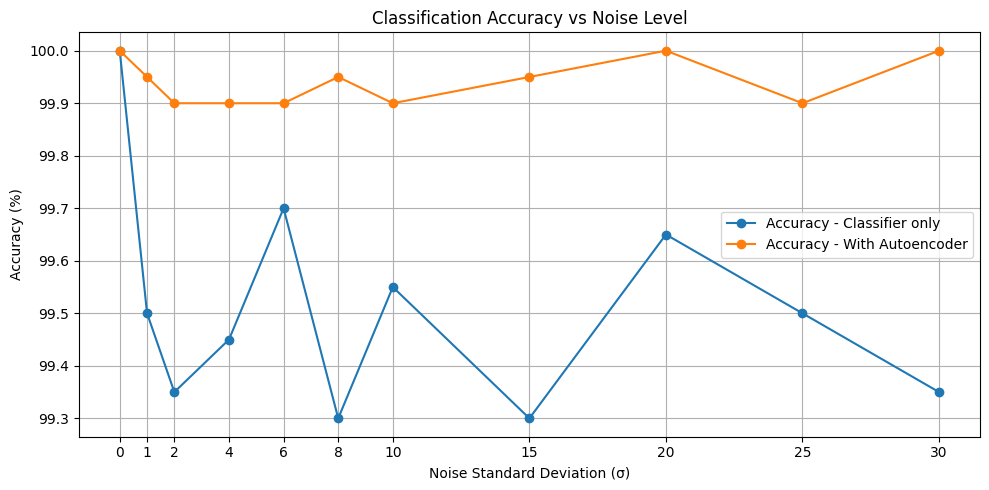

In [52]:
plt.figure(figsize=(10, 5))

plt.plot(noise_levels_with_zero, [100*a for a in acc_raw], label="Accuracy - Classifier only", marker='o')
plt.plot(noise_levels_with_zero, [100*a for a in acc_denoised], label="Accuracy - With Autoencoder", marker='o')

plt.xlabel("Noise Standard Deviation (σ)")
plt.ylabel("Accuracy (%)")
plt.title("Classification Accuracy vs Noise Level")
plt.grid(True)
plt.legend()
plt.xticks(noise_levels_with_zero)
plt.tight_layout()
plt.show()


In [53]:
# Define test noise levels (including 0 noise)
test_noise_levels = [0, 1, 2, 4, 6, 8, 10, 15, 20, 25, 30]

# -----------------------------
# Build Positive Test Data
# -----------------------------
num_pos_total = 1000
num_groups = len(test_noise_levels)  # 11 groups
num_pos_per_group = num_pos_total // num_groups  # floor division: 1000 // 11 = 90
pos_test_clean = images[9000:10000]  # Use the last 1000 neutrino images (clean)

# Split the 1000 images into 11 groups of 90 images each (990 total)
pos_test_list = []
for i in range(num_groups):
    start = i * num_pos_per_group
    end = start + num_pos_per_group
    group = pos_test_clean[start:end]
    pos_test_list.append(group)

# Pad the last group if total < 1000
remainder_pos = num_pos_total - (num_pos_per_group * num_groups)  # 1000 - 990 = 10
if remainder_pos > 0:
    extra = pos_test_clean[:remainder_pos]
    pos_test_list[-1] = np.concatenate([pos_test_list[-1], extra], axis=0)

# For each group, overlay noise according to its designated noise level
pos_test_noisy_list = []
for sigma, group in zip(test_noise_levels, pos_test_list):
    group_noisy = np.array([np.clip(img + np.random.normal(0, sigma, img.shape), 0, None)
                            for img in group])
    pos_test_noisy_list.append(group_noisy)
# Combine all groups
pos_test_noisy = np.concatenate(pos_test_noisy_list, axis=0)
pos_labels = np.ones(pos_test_noisy.shape[0])


In [54]:
# -----------------------------
# Build Negative Test Data
# -----------------------------
num_neg_total = 1000
num_neg_per_group = num_neg_total // num_groups  # 1000 // 11 = 90
neg_test_list = []
for sigma in test_noise_levels:
    group_neg = np.array([np.clip(np.random.normal(0, sigma, (100,100)), 0, None)
                           for _ in range(num_neg_per_group)])
    neg_test_list.append(group_neg)

remainder_neg = num_neg_total - (num_neg_per_group * num_groups)  # 1000 - 990 = 10
if remainder_neg > 0:
    extra_neg = np.array([np.clip(np.random.normal(0, test_noise_levels[-1], (100,100)), 0, None)
                           for _ in range(remainder_neg)])
    neg_test_list[-1] = np.concatenate([neg_test_list[-1], extra_neg], axis=0)

neg_test_noisy = np.concatenate(neg_test_list, axis=0)
neg_labels = np.zeros(neg_test_noisy.shape[0])

In [55]:
# -----------------------------
# Combine and Normalize Test Data
# -----------------------------
X_test = np.concatenate([pos_test_noisy, neg_test_noisy], axis=0)
y_test = np.concatenate([pos_labels, neg_labels], axis=0)

def minmax_norm(img):
    m, M = np.min(img), np.max(img)
    return img if (M - m) == 0 else (img - m) / (M - m)

X_test = np.array([minmax_norm(img) for img in X_test])
X_test = np.expand_dims(X_test, axis=-1)  # shape: (2000, 100, 100, 1)

Overall Test Accuracy: 0.716
Confusion Matrix:
[[1000    0]
 [ 568  432]]


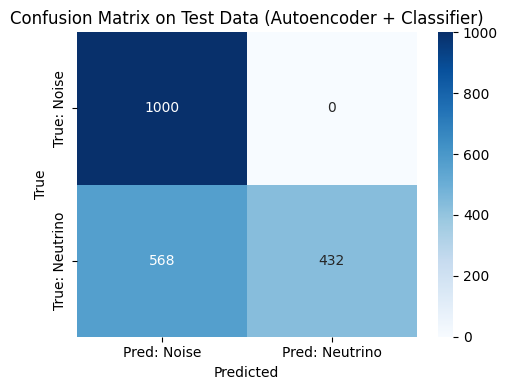

In [56]:
# -----------------------------
# Evaluate the Final System (Autoencoder + Classifier)
# -----------------------------
# First, denoise using the autoencoder
X_test_denoised = autoencoder.predict(X_test, verbose=0)
# Then, get predictions from the classifier (model1)
y_pred_probs = model1.predict(X_test_denoised, verbose=0)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

overall_accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print("Overall Test Accuracy:", overall_accuracy)
print("Confusion Matrix:")
print(cm)

# Plot the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pred: Noise', 'Pred: Neutrino'],
            yticklabels=['True: Noise', 'True: Neutrino'])
plt.title("Confusion Matrix on Test Data (Autoencoder + Classifier)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

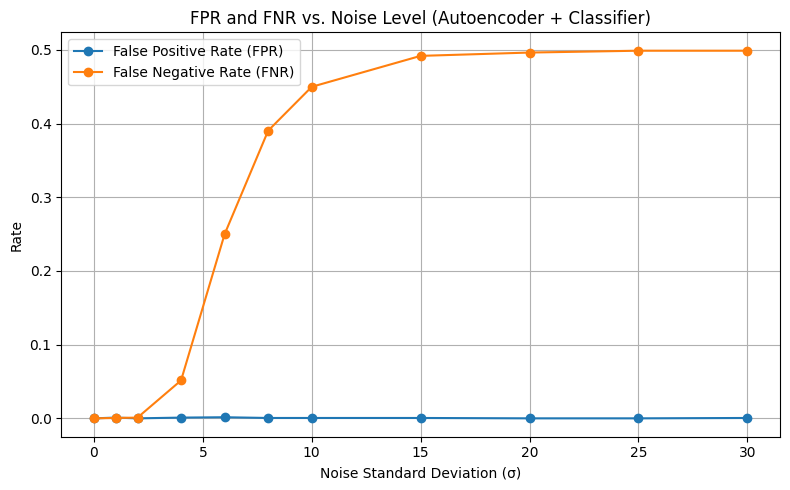

In [66]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Noise levels to test
test_noise_levels = [0, 1, 2, 4, 6, 8, 10, 15, 20, 25, 30]

fpr_auto, fnr_auto = [], []

for sigma in test_noise_levels:
    # --- Positive (neutrino) samples ---
    group = images[9000:10000]  # Last 1000 neutrino images
    group_noisy = np.array([np.clip(img + np.random.normal(0, sigma, img.shape), 0, None)
                            for img in group])

    # --- Negative (blank noise) samples ---
    blank_images = np.array([np.clip(np.random.normal(0, sigma, (100,100)), 0, None)
                             for _ in range(1000)])

    # Combine and normalize
    X_test = np.concatenate([group_noisy, blank_images], axis=0)
    y_test = np.concatenate([np.ones(1000), np.zeros(1000)])

    X_test = np.array([minmax_norm(img) for img in X_test])
    X_test = np.expand_dims(X_test, axis=-1)

    # Autoencoder → Classifier
    X_test_denoised = autoencoder.predict(X_test, verbose=0)
    y_probs = model1.predict(X_test_denoised, verbose=0)
    y_pred = (y_probs > 0.5).astype(int).flatten()

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()

    fpr = fp / (fp + tn + fn + tp) if (fp + tn) > 0 else 0
    fnr = fn / (fn + tp + fp + tn) if (fn + tp) > 0 else 0

    fpr_auto.append(fpr)
    fnr_auto.append(fnr)

# --- Plot ---
plt.figure(figsize=(8, 5))
plt.plot(test_noise_levels, fpr_auto, marker='o', label='False Positive Rate (FPR)')
plt.plot(test_noise_levels, fnr_auto, marker='o', label='False Negative Rate (FNR)')
plt.xlabel("Noise Standard Deviation (σ)")
plt.ylabel("Rate")
plt.title("FPR and FNR vs. Noise Level (Autoencoder + Classifier)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


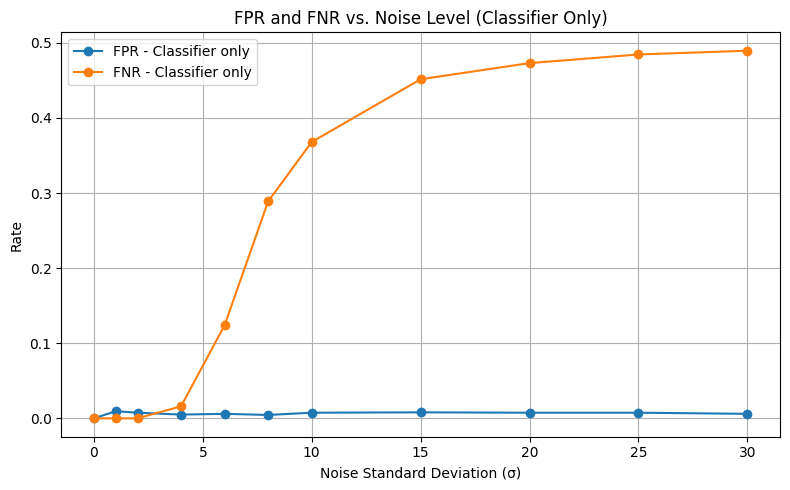

In [69]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Noise levels to test
test_noise_levels = [0, 1, 2, 4, 6, 8, 10, 15, 20, 25, 30]

fpr_raw = []
fnr_raw = []

for sigma in test_noise_levels:
    # --- Positive (noisy neutrino) samples ---
    group = images[9000:10000]  # Last 1000 neutrino images
    group_noisy = np.array([np.clip(img + np.random.normal(0, sigma, img.shape), 0, None)
                            for img in group])

    # --- Negative (blank noise) samples ---
    blank_images = np.array([np.clip(np.random.normal(0, sigma, (100,100)), 0, None)
                             for _ in range(1000)])

    # Combine and normalize
    X_test = np.concatenate([group_noisy, blank_images], axis=0)
    y_test = np.concatenate([np.ones(1000), np.zeros(1000)])

    X_test = np.array([minmax_norm(img) for img in X_test])
    X_test = np.expand_dims(X_test, axis=-1)

    # --- Classifier only ---
    y_probs = model1.predict(X_test, verbose=0)
    y_pred = (y_probs > 0.5).astype(int).flatten()

    # --- Confusion matrix ---
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()

    fpr = fp / (fp + tn + fn + tp) if (fp + tn) > 0 else 0
    fnr = fn / (fn + tp + fp + tn) if (fn + tp) > 0 else 0

    fpr_raw.append(fpr)
    fnr_raw.append(fnr)

# --- Plot ---
plt.figure(figsize=(8, 5))
plt.plot(test_noise_levels, fpr_raw, marker='o', label='FPR - Classifier only')
plt.plot(test_noise_levels, fnr_raw, marker='o', label='FNR - Classifier only')
plt.xlabel("Noise Standard Deviation (σ)")
plt.ylabel("Rate")
plt.title("FPR and FNR vs. Noise Level (Classifier Only)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
